# Plotting

Notebook dedicated to plotting the results of the explainer calculations

In [1]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)




In [34]:
# Choose Data to look at

# can be any of Random, Energy, Gamma or Base
scenario = 'Random'
model_type = 'ML'
# choose parameter configuration

alpha = 1.0
beta = 1.0
gamma = 0.37
delta = 0.3
omega = 1.2

if scenario == 'Random':
    extra_feat = 'random_feature_'
    parameters = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'omega':omega}
    suffix = "params_"+str(parameters['alpha'])+"_"+str(parameters['beta'])+"_"+str(parameters['gamma'])+"_"+str(parameters['delta'])+"_"+str(parameters['omega'])
    features = ['x0', 'v0', 't', 'rand']
    from  RandomFeature import Duffing
    
elif scenario == 'Base':
    extra_feat = 'random_feature_'
    parameters = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'omega':omega}
    suffix = "params_"+str(parameters['alpha'])+"_"+str(parameters['beta'])+"_"+str(parameters['gamma'])+"_"+str(parameters['delta'])+"_"+str(parameters['omega'])
    features = ['x0', 'v0', 't', 'rand']

In [4]:
# load plotting data

data_df = pd.read_csv("Results/explainer_dataframe_"+extra_feat+suffix+".csv")

In [5]:
# generate dataset to enable scaling of values

duffing = Duffing(parameters = parameters)
eom = duffing.eom

end_time = 100
duffing.generate(100, samples = 100, end_time = end_time)
duffing.scale_features()

X = pd.DataFrame(duffing.scaler.inverse_transform(data_df[features]), columns = features)
y = pd.DataFrame(duffing.predict(data_df[features]), columns = ['xt', 'vt'])

Generating Data…: 100%|██████████████████| 100/100 [00:03<00:00, 32.16it/s]


In [6]:
# load neural network

model = tf.keras.models.load_model("Models/ml_model_"+extra_feat+suffix)
history = pickle.load(open('Models/TrainingHistory/'+extra_feat+suffix, "rb"))

In [30]:
# evaluate NN performance

"""
Evaluate Model
"""

# evaluate the fitting validation and training losses
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(data_df[features]), columns=['xt','vt'])

pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

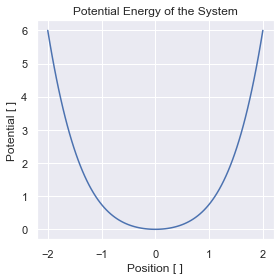

In [47]:
x_potential = np.linspace(-2,2,100)

v_potential = 0
y_potential = (0.5*v_potential**2 + 0.5*alpha*x_potential**2 +0.25*beta*x_potential**4)

f, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))

sns.lineplot(x = x_potential, y=y_potential,ax=axs)

axs.set_xlabel('Position [ ]')
axs.set_ylabel('Potential [ ]')
axs.set_title("Potential Energy of the System")

f.tight_layout()

f.savefig("Images/"+scenario+"/Potential_"+suffix+".svg", dpi='figure')

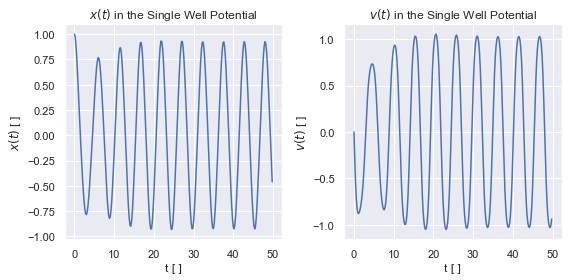

In [95]:
traj_df = pd.DataFrame([[1,0,t/5,0] for t in range(0,250)], columns = ['x0','v0', 't', 'rand'])
traj_df = duffing.scaler.transform(traj_df)
traj_df = pd.DataFrame(duffing.predict(traj_df), columns = ['xt', 'vt'])
# Trajectory Plot
f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4,4]))

sns.lineplot(data = traj_df, x = traj_df.index/5, y='xt',ax=axs[0])

axs[0].set_xlabel(r't [ ]')
axs[0].set_ylabel(r'$x(t)$ [ ]')
axs[0].set_title(r"$x(t)$ in the Single Well Potential")



sns.lineplot(data = traj_df, x = traj_df.index/5, y='vt',ax=axs[1])

axs[1].set_xlabel(r't [ ]')
axs[1].set_ylabel(r'$v(t)$ [ ]')
axs[1].set_title(r"$v(t)$ in the Single Well Potential")



f.tight_layout()

f.savefig("Images/"+scenario+"/Trajectory"+suffix+".svg", dpi='figure')

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


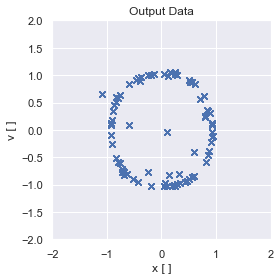

In [90]:
# Loss Plot ML Model
f, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))


# True Values Plot
sns.scatterplot(data = y.iloc[:,:], x = 'xt', y='vt',ax=axs, marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Output Data")

f.tight_layout()

f.savefig("Images/"+scenario+"/OutputData_"+suffix+".svg", dpi='figure')

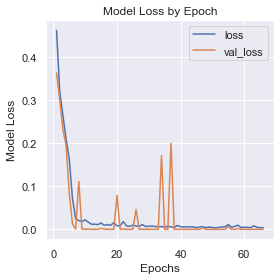

In [37]:
# Model Accuracy
f, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))

sns.lineplot(data = history, x = epochs, y='loss',ax=axs, label='loss')
sns.lineplot(data = history, x = epochs, y='val_loss',ax=axs, label='val_loss')

axs.set_xlabel('Epochs')
axs.set_ylabel('Model Loss')
axs.set_title("Model Loss by Epoch")
axs.legend()

f.tight_layout()

f.savefig("Images/"+scenario+"/"+model_type+"Model/loss_"+suffix+".svg", dpi='figure')

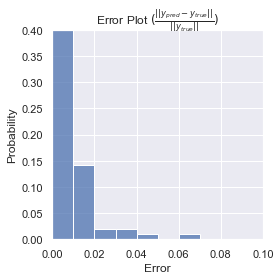

In [39]:
# Model Error

f, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))

# Error Plot for ML Predictions
sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.01, ax=axs)

axs.set(xlim=(0, 0.1), ylim=(0, 0.4))
axs.set_xlabel('Error')
axs.set_ylabel('Probability')
axs.set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")

f.tight_layout()

f.savefig("Images/"+scenario+"/"+model_type+"Model/error_plot_"+suffix+".svg", dpi='figure')

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


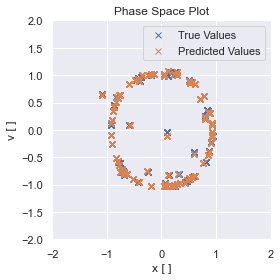

In [52]:
# Loss Plot ML Model
f, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))


# True Values Plot
sns.scatterplot(data = y.iloc[:,:], x = 'xt', y='vt',ax=axs,label='True Values', marker='x', linewidth = 1)
# ML Values Plot
sns.scatterplot(data = y_pred.iloc[:,:], x='xt', y='vt',ax=axs,label='Predicted Values',  marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/"+scenario+"/"+model_type+"Model/model_predictions_"+suffix+".svg", dpi='figure')

In [23]:
big_df = data_df.iloc[:300,:]

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of 

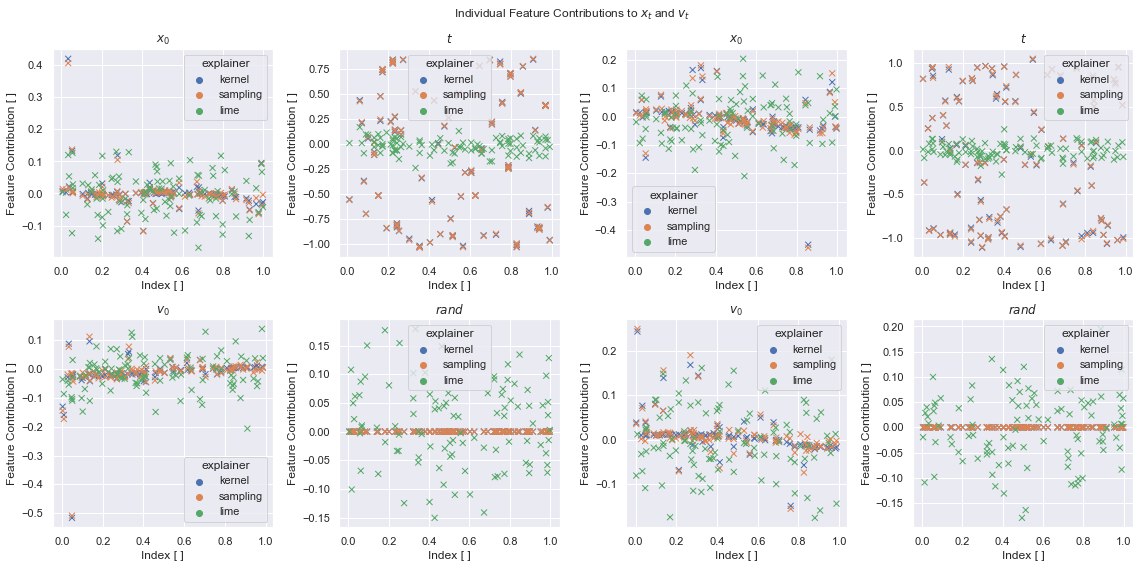

In [53]:
# individual feature attributions

# Individual Feature Contributions
f, axs = plt.subplots(2, 4, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4,4,4]))

sns.scatterplot(x='x0', y="xt_x0", data=big_df, ax=axs[0,0], marker = 'x', linewidth = 1, hue = "explainer")

axs[0,0].set_title(r"$x_0$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="xt_v0", data=big_df, ax=axs[1,0], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,0].set_title(r"$v_0$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='t', y="xt_t", data=big_df, ax=axs[0,1], marker = 'x', linewidth = 1, hue = "explainer")
axs[0,1].set_title(r"$t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='rand', y="xt_rand", data=big_df, ax=axs[1,1], marker = 'x', linewidth = 1, hue = "explainer")

axs[1,1].set_title(r"$rand$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')


sns.scatterplot(x='x0', y="vt_x0", data=big_df, ax=axs[0,2], marker = 'x', linewidth = 1, hue = "explainer")

axs[0,2].set_title(r"$x_0$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="vt_v0", data=big_df, ax=axs[1,2], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,2].set_title(r"$v_0$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="vt_t", data=big_df, ax=axs[0,3], marker = 'x', linewidth = 1, hue = "explainer")
axs[0,3].set_title(r"$t$")
axs[0,3].set_xlabel('Index [ ]')
axs[0,3].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='rand', y="vt_rand", data=big_df, ax=axs[1,3], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,3].set_title(r"$rand$")
axs[1,3].set_xlabel('Index [ ]')
axs[1,3].set_ylabel('Feature Contribution [ ]')



f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$")

f.tight_layout()
f.savefig("Images/"+scenario+"/feature_importance_"+suffix+".svg", dpi='figure')

In [56]:
# Convert Data to Long Form to enable plotting with sns barplot

plot_cols = ['xt_x0', 'xt_v0', 'xt_t', 'xt_rand', 'vt_x0', 'vt_v0', 'vt_t', 'vt_rand', 'explainer']
agg_df = big_df[plot_cols].copy().set_index('explainer')
temp_df = pd.DataFrame()
agg_df_2 = pd.DataFrame()
for j, col in enumerate(agg_df.columns[:8]):
    for expl in agg_df.index.unique():
        temp_df['value'] = agg_df.loc[expl][col].values
        temp_df['feature'] = col
        temp_df['explainer'] = expl
        agg_df_2 = agg_df_2.append(temp_df)

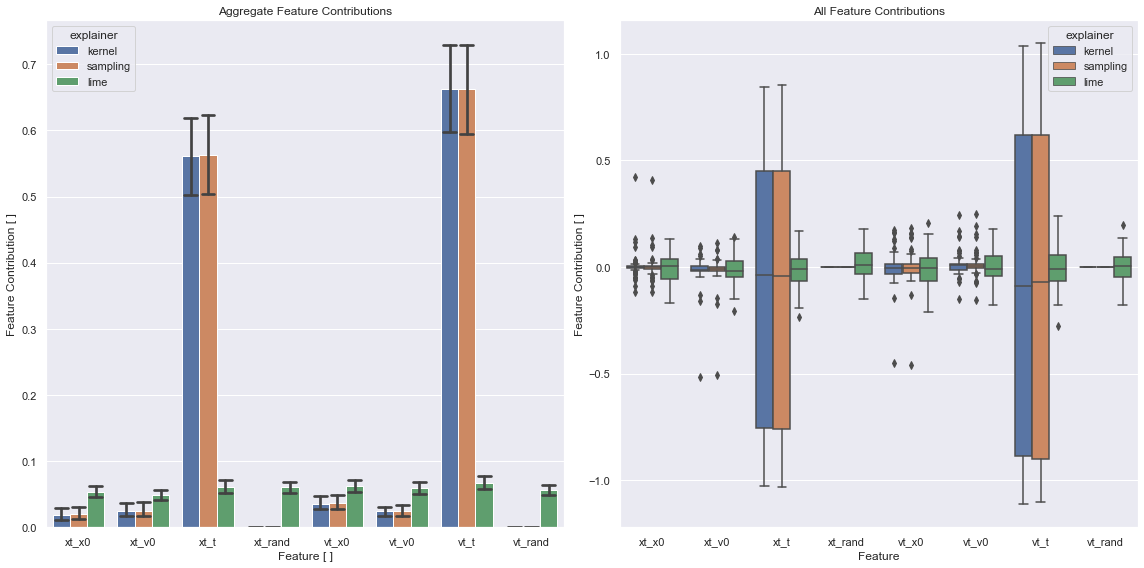

In [57]:
# aggregated feature importance

# Aggregated

f, axs = plt.subplots(1, 2, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4]))


sns.barplot(data=agg_df_2, x = 'feature', y = np.abs(agg_df_2['value']), hue = 'explainer', ax = axs[0], ci = 95, capsize=.2)

axs[0].set_title(r"Aggregate Feature Contributions")
axs[0].set_xlabel('Feature [ ]')
axs[0].set_ylabel('Feature Contribution [ ]')

sns.boxplot(data=agg_df_2, x = 'feature', y = 'value', ax = axs[1], hue = 'explainer')
axs[1].set_title(r"All Feature Contributions")
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Feature Contribution [ ]')


f.tight_layout()

f.savefig("Images/"+scenario+"/aggregated_feature_importance_"+suffix+".svg", dpi='figure')

In [ ]:
# numerical explainer convergence study

# choose random point from dataset
x_val = np.random.choice(choice, 1)



In [ ]:
class MyLime(shap.other.LimeTabular):
    def __init__(self, model, data, mode="classification"):
        self.model = model
        assert mode in ["classification", "regression"]
        self.mode = mode

        if str(type(data)).endswith("pandas.core.frame.DataFrame'>"):
            data = data.values
        self.data = data
        self.explainer = lime.lime_tabular.LimeTabularExplainer(data, mode=mode)
        self.out_dim = 1#self.model(data[0:1]).shape[1]
            
    def attributions(self, X, num_samples=500, num_features=None):
        try:
            num_features = X.shape[1] if num_features is None else num_features
        except:
            print('exception')
            num_features = 1
        if str(type(X)).endswith("pandas.core.frame.DataFrame'>"):
            X = X.values
            
        out = [np.zeros(X.shape) for j in range(len(self.model))]
        for i in tqdm(range(X.shape[0]), desc="Calculating Lime…", ascii=False, ncols=75):
            exp1 = self.explainer.explain_instance(X[i], self.model[0], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            exp2 = self.explainer.explain_instance(X[i], self.model[1], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            for k, v in exp1.local_exp[1]: 
                out[0][i,k] = v
            for k, v in exp2.local_exp[1]: 
                out[1][i,k] = v
          
        return out

In [ ]:
# lime convergence study
# use x_val from above



In [ ]:
    def __init__(self,
                 training_data,
                 mode="classification",
                 training_labels=None,
                 feature_names=None,
                 categorical_features=None,
                 categorical_names=None,
                 kernel_width=None,
                 kernel=None,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 discretize_continuous=True,
                 discretizer='quartile',
                 sample_around_instance=False,
                 random_state=None,
                 training_data_stats=None):

In [96]:
#!/usr/bin/env python

import os

def mkdir_p(dir):
    '''make a directory (dir) if it doesn't exist'''
    if not os.path.exists(dir):
        os.mkdir(dir)
    

job_directory = "%s/.job" %os.getcwd()
#scratch = os.environ['SCRATCH']
#data_dir = os.path.join(scratch, '/project/ExplainabilityArray')

# Make top level directories
mkdir_p(job_directory)
#mkdir_p(data_dir)

Settings=["Base", "Random", "Energy","Gamma"]
Models=["True", "Complex", "Simple"]


lizards=["LizardA","LizardB"]

for Setting in Settings:
    for Model in Models:
        job_file=os.path.join(job_directory, Setting+Model+"s.job")
        #explainer_data = os.path.join(data_dir, Setting+Model)
        

    # Create lizard directories
    #mkdir_p(explainer_data)

    with open(job_file) as fh:
        fh.writelines("#!/bin/bash\n")
        fh.writelines("#SBATCH --partition=daily\n")
        fh.writelines("#SBATCH --time=23:30:00\n")
        fh.writelines("#SBATCH --clusters=merlin6\n")
        fh.writelines("#SBATCH --nodes=1\n")
        fh.writelines("#SBATCH --ntasks=1\n")
        fh.writelines("#SBATCH --ntasks-per-node=1\n")
        fh.writelines("#SBATCH --cpus-per-task=1\n")
        fh.writelines("#SBATCH --#SBATCH --output=/data/user/grosche_w/XAI/XAI/FinalRuns/Logs/"+Setting+Params+"_out_%j.log\n")
        fh.writelines("#SBATCH --job-name="+{Setting}+{Params}+"_run\n")
        fh.writelines("""NOW=$(date +"%m-%d-%Y")\n""")
        fh.writelines("""echo "Starting time: $NOW, $NOW2"\n""")
        fh.writelines("""echo ""\n""")
        fh.writelines("""START=$(date +%s)\n""")
        fh.writelines("""module use unstable\n""")
        fh.writelines("""module load anaconda\n""")
        fh.writelines("""conda activate /data/user/grosche_w/myenv\n""")
        fh.writelines("python3 "+Setting+"Feature.py\n")
        fh.writelines("""END=$(date +%s)\n""")
        fh.writelines("""DIFF=$(( $END - $START ))\n""")
        fh.writelines("""echo "It took $DIFF seconds"\n""")
        fh.writelines("""NOW=$(date +"%m-%d-%Y")\n""")
        fh.writelines("""NOW2=$(date +"%r")""")
        fh.writelines("""echo "Ending time: $NOW, $NOW2"\n""")
        fh.writelines("""echo """"")
       
   

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Polybox\\SyncFolder\\XAI\\Plotting/.job\\BaseSimples.job'